This notebook tests the generation of the CLEVR with masks dataset.

# Image generation (example)

In [3]:
%cd image_generation
!./blender/blender --background \
    --python render_images.py -- \
    --num_images 10 --use_gpu 1 --min_objects 2 --max_objects 6
%cd ..

/dfs/user/liuk/reasoning/clevr_dataset_gen/image_generation
AL lib: (EE) ALCplaybackOSS_open: Could not open /dev/dsp: No such file or directory
found bundled python: /dfs/user/liuk/reasoning/clevr_dataset_gen/image_generation/blender/2.78/python
read blend: data/base_scene.blend
convertViewVec: called in an invalid context
convertViewVec: called in an invalid context
convertViewVec: called in an invalid context
0.2498259730027308 0.4 right
BROKEN MARGIN!
0.11816491454907707 0.4 left
BROKEN MARGIN!
0.31307834991033046 0.4 front
BROKEN MARGIN!
0.06981415725537676 0.4 front
BROKEN MARGIN!
0.1765139023033555 0.4 behind
BROKEN MARGIN!
convertViewVec: called in an invalid context
Fra:1 Mem:16.59M (0.00M, Peak 16.59M) | Time:00:00.00 | Preparing Scene data
Fra:1 Mem:25.30M (0.00M, Peak 26.28M) | Time:00:00.02 | Preparing Scene data
Fra:1 Mem:25.30M (0.00M, Peak 26.28M) | Time:00:00.02 | Creating Shadowbuffers
Fra:1 Mem:25.30M (0.00M, Peak 26.28M) | Time:00:00.02 | Raytree.. preparing
Fra:1 M

# Single CLEVR_scenes.json generation

In [76]:
%cd image_generation
!python collect_scenes.py --date "$(date)" --input_dir /dfs/user/tailin/.results/CLEVR_relation/mpi-0-10000/scenes --output /dfs/user/tailin/.results/CLEVR_relation/mpi-0-10000/CLEVR_scenes.json
%cd ..

/dfs/user/liuk/reasoning/clevr_dataset_gen/image_generation
CLEVR_new_000000.png
CLEVR_new_000001.png
CLEVR_new_000002.png
CLEVR_new_000003.png
CLEVR_new_000004.png
CLEVR_new_000005.png
CLEVR_new_000006.png
CLEVR_new_000007.png
CLEVR_new_000008.png
CLEVR_new_000009.png
CLEVR_new_000010.png
CLEVR_new_000011.png
CLEVR_new_000012.png
CLEVR_new_000013.png
CLEVR_new_000014.png
CLEVR_new_000015.png
CLEVR_new_000016.png
CLEVR_new_000017.png
CLEVR_new_000018.png
CLEVR_new_000019.png
CLEVR_new_000020.png
CLEVR_new_000021.png
CLEVR_new_000022.png
CLEVR_new_000023.png
CLEVR_new_000024.png
CLEVR_new_000025.png
CLEVR_new_000026.png
CLEVR_new_000027.png
CLEVR_new_000028.png
CLEVR_new_000029.png
CLEVR_new_000030.png
CLEVR_new_000031.png
CLEVR_new_000032.png
CLEVR_new_000033.png
CLEVR_new_000034.png
CLEVR_new_000035.png
CLEVR_new_000036.png
CLEVR_new_000037.png
CLEVR_new_000038.png
CLEVR_new_000039.png
CLEVR_new_000040.png
CLEVR_new_000041.png
CLEVR_new_000042.png
CLEVR_new_000043.png
CLEVR_new_000044

# Question template generation

In [4]:
!pip install pyjson5

     |████████████████████████████████| 232 kB 6.6 MB/s eta 0:00:01


In [5]:
%cd relation_generator
!python generate_relations.py
%cd ..

/dfs/user/liuk/reasoning/clevr_dataset_gen/relation_generator
Generating relations
Saving templates to ../question_generation/babyarc
Generating relations for same_shape and same_shape
Generating relations for same_shape and same_material
Generating relations for same_shape and same_size
Generating relations for same_shape and same_color
Generating relations for same_material and same_shape
Generating relations for same_material and same_material
Generating relations for same_material and same_size
Generating relations for same_material and same_color
Generating relations for same_size and same_shape
Generating relations for same_size and same_material
Generating relations for same_size and same_size
Generating relations for same_size and same_color
Generating relations for same_color and same_shape
Generating relations for same_color and same_material
Generating relations for same_color and same_size
Generating relations for same_color and same_color
/dfs/user/liuk/reasoning/clevr_dat

# Question generation

In [77]:
%cd question_generation/
!python generate_questions.py --input_scene_file /dfs/user/tailin/.results/CLEVR_relation/mpi-0-10000/CLEVR_scenes.json --output_questions_file /dfs/user/tailin/.results/CLEVR_relation/mpi-0-10000/questions.json --template_dir babyarc --max-num-objects 6
%cd ..

/dfs/user/liuk/reasoning/clevr_dataset_gen/question_generation
Read 32 templates from disk
starting image CLEVR_new_000000.png (1 / 10000)
resetting counts
starting image CLEVR_new_000001.png (2 / 10000)
starting image CLEVR_new_000002.png (3 / 10000)
starting image CLEVR_new_000003.png (4 / 10000)
starting image CLEVR_new_000004.png (5 / 10000)
starting image CLEVR_new_000005.png (6 / 10000)
starting image CLEVR_new_000006.png (7 / 10000)
starting image CLEVR_new_000007.png (8 / 10000)
starting image CLEVR_new_000008.png (9 / 10000)
starting image CLEVR_new_000009.png (10 / 10000)
starting image CLEVR_new_000010.png (11 / 10000)
starting image CLEVR_new_000011.png (12 / 10000)
starting image CLEVR_new_000012.png (13 / 10000)
starting image CLEVR_new_000013.png (14 / 10000)
starting image CLEVR_new_000014.png (15 / 10000)
starting image CLEVR_new_000015.png (16 / 10000)
starting image CLEVR_new_000016.png (17 / 10000)
starting image CLEVR_new_000017.png (18 / 10000)
starting image CLEV

# Question analysis

In [2]:
from collections import defaultdict
import json
from typing import List

from relation_generator.generate_relations import RELATIONS

def get_unique_task_string(program: List[str]):
    """
    Parses the program for a given question and returns a unique string that identifies the 
    babyARC task that it embodies.

    This function is somewhat hacky in that it doesn't deal with the AST directly, but it
    works for the generated babyARC template programs.
    """
    inputs = []
    object_str = []
    for node in program:
        # Generate a new object str every time we see a new "scene" (which implies
        # a new object)
        if node["type"] == "scene":
            if len(object_str) != 0:
                inputs.append(",".join(object_str))
                object_str = []
            continue

        # If we're not at a scene, then we're in the middle of an object
        if node["type"].startswith("filter_"):
            # This node filters some property of the input. Let's consider it.
            object_str.append(node["type"][7:] + "=" + node["value_inputs"][0])
    inputs.append(",".join(object_str))
    relations = sorted([node["type"] for node in program if node["type"] in RELATIONS])
    
    return "+".join(relations) + "-" + ";".join(inputs)


# Load the question data
file = "question_generation/questions.json"
with open(file) as f:
    data = json.load(f)
question_list = data["questions"]

observed_question_types = dict()

# Count the number of times each question type occurs
for question in question_list:
    template_filename = question["template_filename"]
    question_family_index = question["question_family_index"]
    program = question["program"]
    image = question["image"]

    task_str = get_unique_task_string(program)

    if task_str not in observed_question_types:
        observed_question_types[task_str] = {"count": 0, "questions": [], "images": []}
    
    observed_question_types[task_str]["count"] += 1
    observed_question_types[task_str]["questions"].append(question)
    observed_question_types[task_str]["images"].append(image)
for task_str, data in observed_question_types.items():
    print("{} - {}".format(task_str, data["count"]))

same_shape-color=purple,material=metal - 2
same_shape+same_shape-material=rubber;size=large,color=green,shape=sphere - 1
same_material+same_shape-color=green;size=large,color=purple,shape=sphere - 1
same_shape-color=cyan,shape=cylinder - 2
same_shape+same_size-color=purple,material=rubber;color=green - 1
same_color+same_size-size=large,material=rubber;size=large,color=cyan,shape=cylinder - 1
same_color-size=large,material=rubber,shape=sphere - 8
same_color+same_shape-material=rubber;size=large,color=cyan,material=metal,shape=cylinder - 1
same_color+same_size-material=rubber;color=cyan,shape=sphere - 1
same_size-size=small,color=red,material=metal - 2
same_material+same_size-size=small,color=red;color=green,material=metal,shape=sphere - 1
same_material-size=large,color=cyan,shape=cylinder - 2
same_size-size=small,color=red - 4
same_material-color=brown,shape=cylinder - 1
same_material+same_size-color=green;color=cyan,material=metal,shape=sphere - 1
same_material-color=brown - 7
same_mat

In [34]:
import pandas as pd

df = pd.DataFrame.from_dict(observed_question_types, orient='index')

In [42]:
df.sort_values(by=["count"], ascending=False).images[0]

['CLEVR_new_000001',
 'CLEVR_new_000002',
 'CLEVR_new_000002',
 'CLEVR_new_000003']

In [3]:
observed_question_types["same_size-size=large,color=purple,material=metal"]

{'count': 5,
 'questions': [{'split': 'new',
   'image_filename': 'CLEVR_new_000010.png',
   'image_index': 10,
   'image': 'CLEVR_new_000010',
   'question': 'What is the object with the same_size as the large purple metallic thing?',
   'program': [{'type': 'scene',
     'inputs': [],
     '_output': [0, 1, 2],
     'value_inputs': []},
    {'type': 'filter_size',
     'inputs': [0],
     '_output': [0, 2],
     'value_inputs': ['large']},
    {'type': 'filter_color',
     'inputs': [1],
     '_output': [2],
     'value_inputs': ['purple']},
    {'type': 'filter_material',
     'inputs': [2],
     '_output': [2],
     'value_inputs': ['metal']},
    {'type': 'unique', 'inputs': [3], '_output': 2, 'value_inputs': []},
    {'type': 'same_size', 'inputs': [4], '_output': [0], 'value_inputs': []},
    {'type': 'unique', 'inputs': [5], '_output': 0, 'value_inputs': []}],
   'answer': 0,
   'template_filename': 'same_size-same_shape.json',
   'question_family_index': 0,
   'question_index'

# Dataset

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from dataset import ClevrRelationDataset

In [21]:
dataset = ClevrRelationDataset(image_dir="/dfs/user/tailin/.results/CLEVR_relation/mpi-0-10000/images",
                               question_dir="/dfs/user/tailin/.results/CLEVR_relation/mpi-0-10000",
                               output_type="mask-only")

100%|██████████| 87528/87528 [51:49<00:00, 28.15it/s]  

Loaded 608 tasks.


In [22]:
dataset.save("/dfs/user/tailin/.results/CLEVR_relation/relations-dataset-2021-08-18-608-tasks.pt")

[autoreload of PIL.PngImagePlugin failed: Traceback (most recent call last):
  File "/dfs/user/liuk/miniconda3/envs/reasoning/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/dfs/user/liuk/miniconda3/envs/reasoning/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/dfs/user/liuk/miniconda3/envs/reasoning/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/dfs/user/liuk/miniconda3/envs/reasoning/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/dfs/user/liuk/miniconda3/envs/reasoning/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/dfs/user/liuk/miniconda3/envs/reasoning/lib/python3.7/site-pac

same_material-color=blue
What is the object with the same_material as the blue object?


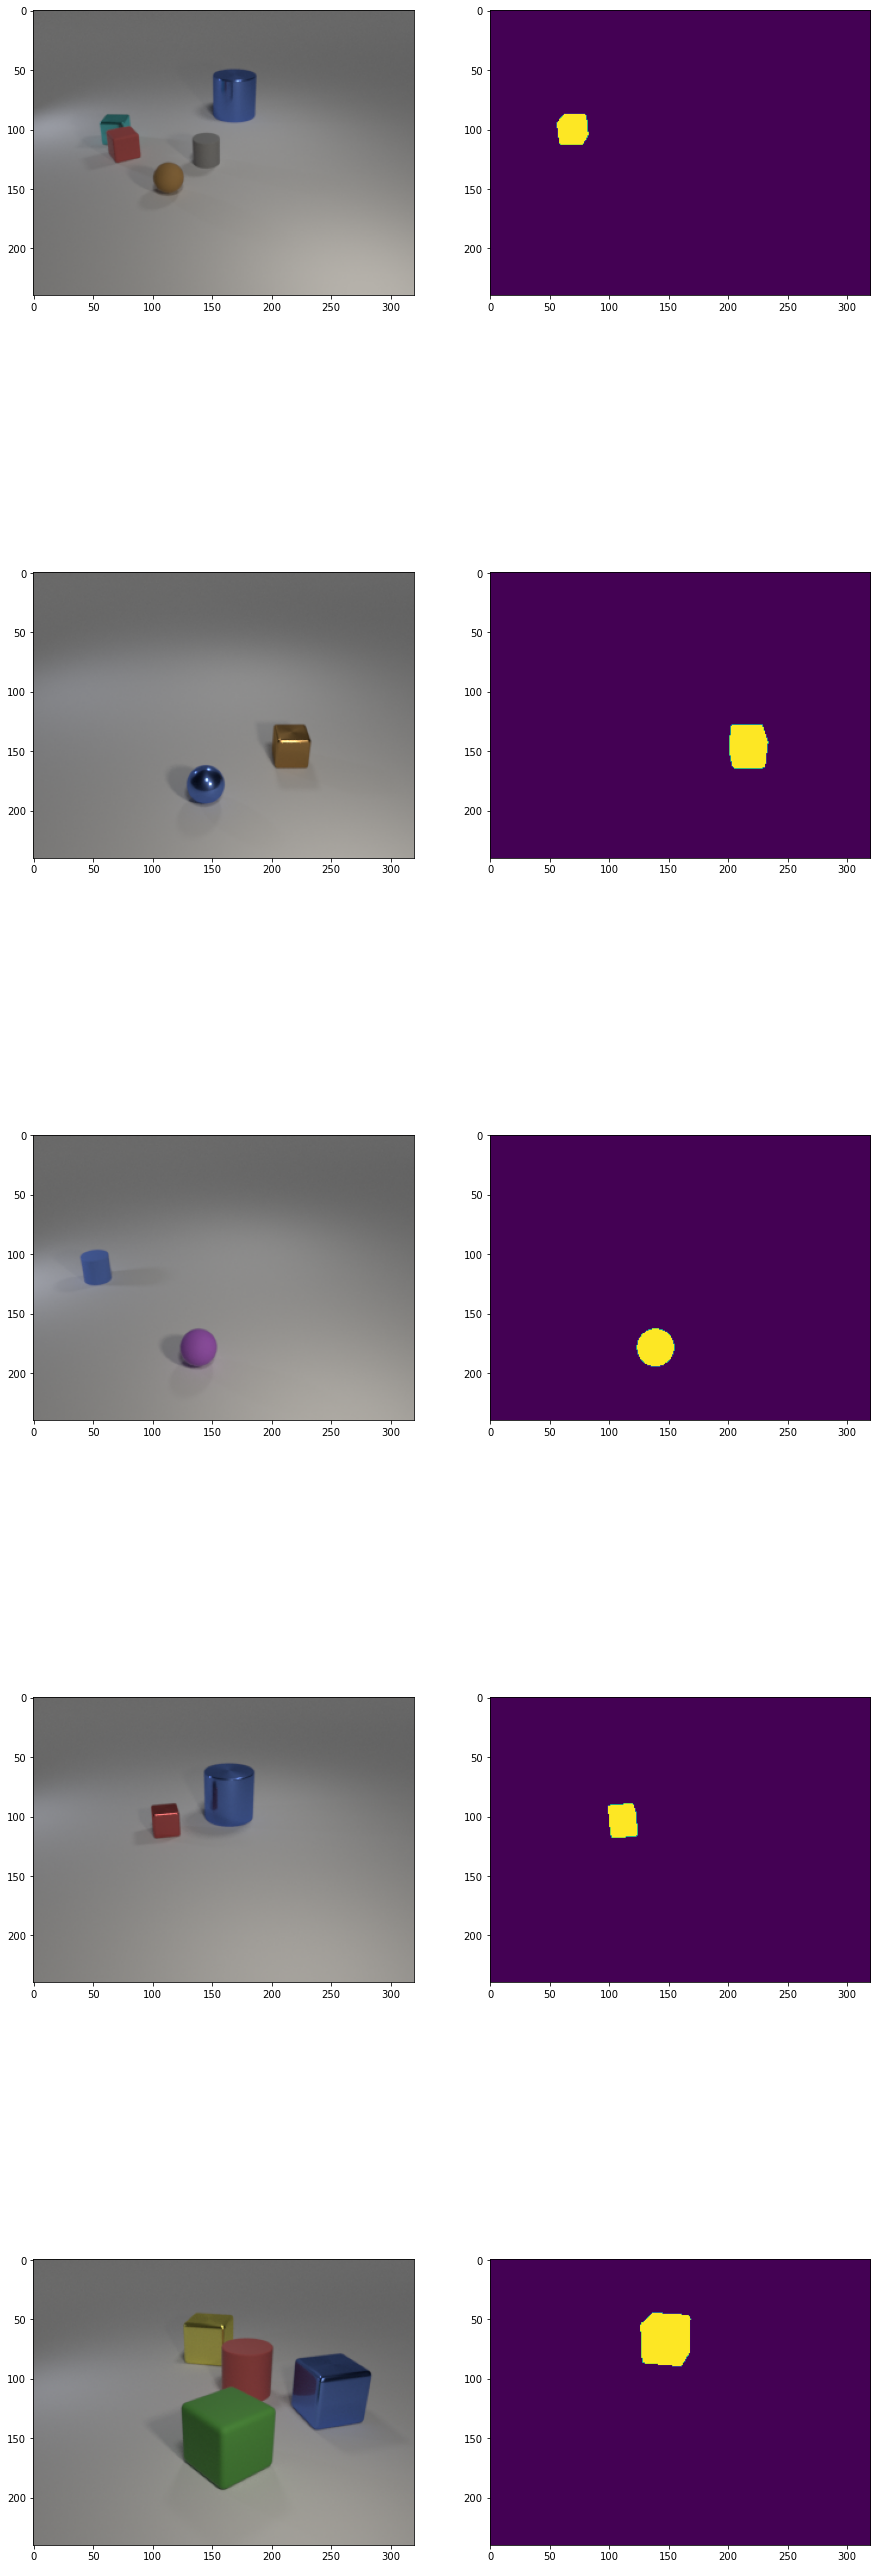

In [20]:
# Visualize the dataset

import matplotlib.pyplot as plt

el = dataset[0]

# Find a compound task
# for el in dataset:
#     if "+" in el["task_str"]:
#         break
# else:
#     assert False
    
print(el["task_str"])
print(el["questions"][0]["question"])

plt.figure(figsize=(15,50)) # specifying the overall grid size

for i in range(min(len(el["inputs"]), 5)):
    plt.subplot(len(el["inputs"]),2, 2 * i + 1)
    plt.imshow(el["inputs"][i]["image"].permute(1, 2, 0))
    plt.subplot(len(el["inputs"]),2, 2 * i + 2)
    plt.imshow(el["outputs"][i].permute(1, 2, 0))

plt.show()

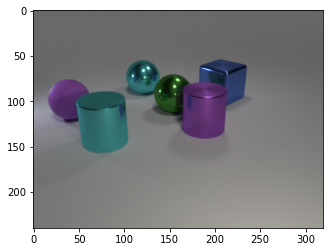

In [12]:
from PIL import Image
plt.imshow(Image.open("/dfs/user/tailin/.results/CLEVR_relation/test1/0/images/CLEVR_new_000000.png"))